In [2]:
using PlotlyJS
include("../model/utils.jl")
include("../model/unit_commitment.jl")
include("../model/economic_dispatch.jl")
include("./plotting.jl")
include("./processing.jl")

parquet_to_solution (generic function with 1 method)

In [3]:
folder_path = joinpath(".","output")
solution_folders = ["n_15", "n_45", "n_75", "n_106", "n_136", "n_167", "n_197", "n_228", "n_259", "n_289"] 
# solution_folders = ["n_15", "n_45", "n_75", "n_106", "n_136", "n_167", "n_197"] 
# solution_folders = union(solution_folders, ["n_69-104", "n_219-240", "n_354-128"])
# solution_folders = ["n_69-104-219-240-354-128"]

read = true
if read
    keys = [:demand, :generation, :storage, :reserve, :energy_reserve, :scalar]
    s_uc = [parquet_to_solution("s_uc", joinpath(folder_path, s)) for s in solution_folders]
    s_ed = [parquet_to_solution("s_ed", joinpath(folder_path, s)) for s in solution_folders]
    s_uc = NamedTuple(k => vcat([s[k] for s in s_uc]...) for k in keys)
    s_ed = NamedTuple(k => vcat([s[k] for s in s_ed]...) for k in keys)
end

write = false
if write
    name = "n_$(replace(join(solution_folders, "-"), "n_" =>""))"
    s_uc = NamedTuple(k => vcat([s[k] for s in s_uc]...) for k in keys)
    solution_to_parquet(s_uc, "s_uc", joinpath(folder_path, name))
    solution_to_parquet(s_ed, "s_uc", joinpath(folder_path, name))
end

reading...
./output/n_15/s_uc_demand.parquet
./output/n_15/s_uc_generation.parquet
./output/n_15/s_uc_storage.parquet
./output/n_15/s_uc_reserve.parquet
./output/n_15/s_uc_energy_reserve.parquet
./output/n_15/s_uc_scalar.parquet
...done
reading...
./output/n_45/s_uc_demand.parquet
./output/n_45/s_uc_generation.parquet
./output/n_45/s_uc_storage.parquet
./output/n_45/s_uc_reserve.parquet
./output/n_45/s_uc_energy_reserve.parquet
./output/n_45/s_uc_scalar.parquet
...done
reading...
./output/n_75/s_uc_demand.parquet
./output/n_75/s_uc_generation.parquet
./output/n_75/s_uc_storage.parquet
./output/n_75/s_uc_reserve.parquet
./output/n_75/s_uc_energy_reserve.parquet
./output/n_75/s_uc_scalar.parquet
...done
reading...
./output/n_106/s_uc_demand.parquet
./output/n_106/s_uc_generation.parquet
./output/n_106/s_uc_storage.parquet
./output/n_106/s_uc_reserve.parquet
./output/n_106/s_uc_energy_reserve.parquet
./output/n_106/s_uc_scalar.parquet
...done
reading...
./output/n_136/s_uc_demand.parquet


In [4]:
thres =.001 # 1 Watt
f_LOL(x,y) = 
    (LLD_h=count(x.>thres),
    # LOLP=count(x.>thres)/length(y)*100,
    ENS_MWh = sum(x),
    # LOL_percentage = sum(x)/(sum(y) + sum(x))*100,
    Demand_MWh = (sum(y) + sum(x)),
    )
f_CUR(x,y) =     
    (CURD_h=count(x.>thres),
    # CURP=count(x.>thres)/length(y)*100,
    CUR_MWh = sum(x),
    # CUR_percentage = sum(x)/(sum(y) + sum(x))*100,
    RES_production_MWh = (sum(y) + sum(x)),
    )

f_CUR (generic function with 1 method)

In [5]:
group_by = [:configuration, :day]
filter = in(["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic", "net_generation"]).(s_ed.generation.resource)

gdf_LOL = combine(groupby(s_ed.demand, union([:iteration], group_by)), [:LOL_MW, :demand_MW] => ((x,y)->f_LOL(x,y)) => AsTable)
gdf_CUR = combine(groupby(s_ed.generation[filter,:], union([:iteration], group_by)), [:curtailment_MW, :production_MW] =>((x,y) -> f_CUR(x,y))=> AsTable)
# gdf_SCALAR = combine(groupby(s_ed.scalar, union([:iteration], group_by)), [:objective_value] => (x -> (objective_value = sum(x))) => AsTable)
gdf_LOL_CUR = outerjoin(gdf_LOL, gdf_CUR, on = union([:iteration], group_by))

LOL = combine(groupby(gdf_LOL, group_by), [:LLD_h, :ENS_MWh] => ((x,y)->(LOLE = mean(x), EENS = mean(y))) => AsTable)
CUR = combine(groupby(gdf_CUR, group_by), [:CURD_h, :CUR_MWh] => ((x,y)->(CURE = mean(x), ECUR = mean(y))) => AsTable)
SCALAR = combine(groupby(s_ed.scalar, group_by), :objective_value => mean => :EOV)
LOL_CUR = outerjoin(LOL, CUR, SCALAR, on=[:configuration, :day])
LOL_CUR


Row,configuration,day,LOLE,EENS,CURE,ECUR,EOV
,Symbol,Int64,Float64?,Float64?,Float64?,Float64?,Float64?
1,base_ramp_storage_reserve,15,1.07,114.33,0.0,-7.14673e-13,1.15294e8
2,base_ramp_storage_envelopes,15,1.28,114.33,0.13,4.50941,1.15294e8
3,base_ramp_storage_energy_reserve_cumulated,15,0.77,114.33,0.0,-4.587e-13,1.15294e8
4,base_ramp_storage_energy_reserve_cumulated,45,0.76,110.271,0.0,6.1807e-13,1.1127e8
5,base_ramp_storage_reserve,45,0.99,110.271,0.0,7.70646e-13,1.1127e8
6,base_ramp_storage_envelopes,45,1.27,110.271,0.0,7.90541e-13,1.1127e8
7,base_ramp_storage_envelopes,75,0.17,11.7298,0.0,-1.13243e-14,1.26462e7
8,base_ramp_storage_energy_reserve_cumulated,75,0.13,11.7298,0.0,-1.50866e-13,1.26462e7
9,base_ramp_storage_reserve,75,0.18,11.7298,0.0,-1.14153e-14,1.26459e7


In [6]:
CSV.write("LOL_CUR.csv",LOL_CUR)

"LOL_CUR.csv"

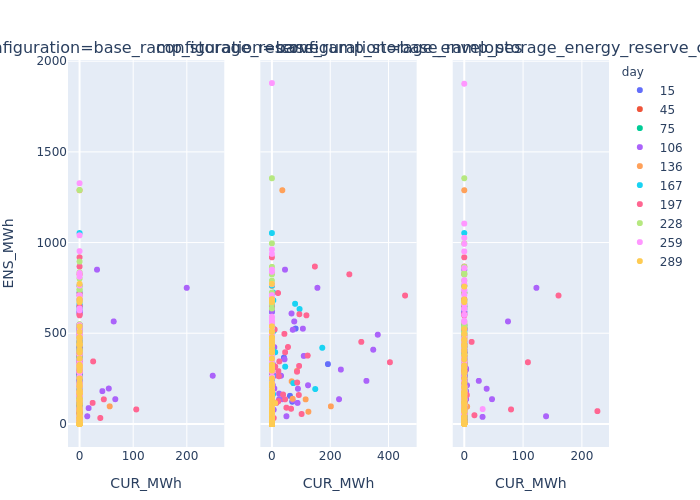

In [7]:
plot(gdf_LOL_CUR, x = :CUR_MWh, y = :ENS_MWh, facet_col = :configuration, text = :iteration, color= :day, mode="markers")

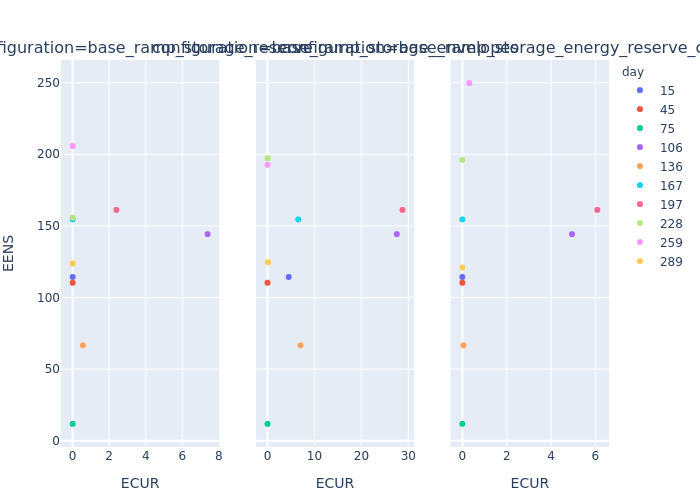

In [8]:
# plot(LOL_CUR, x = :LOLE, y = :EENS, facet_col = :day, group = :configuration, marker_color = :EOV_M, mode = "markers", marker=attr(showscale=true))
# configs
plot(LOL_CUR, x = :ECUR, y = :EENS, facet_col = :configuration, mode = "markers", text = :day, color=:day) # marker=attr(showscale=true, coloraxis="coloraxis", color=:day

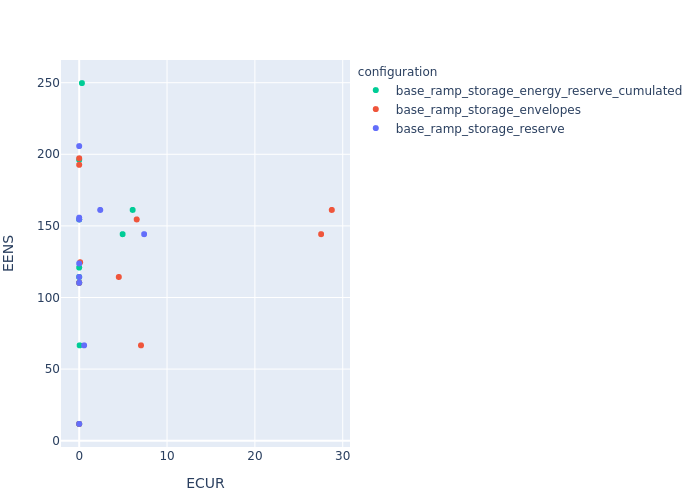

In [9]:
plot(LOL_CUR, x = :ECUR, y = :EENS, text = :day, color = :configuration, mode = "markers")

In [10]:
# plot(gdf_CUR, y = :CURP, x = :CUR_MWh, facet_col = :configuration, facet_row = :day, color= :iteration, mode="markers")

In [11]:
# plot(gdf_LOL, x = :LOL_percentage, kind="histogram", facet_col = :configuration, facet_row = :day, histonorm = "percent")

In [12]:
# filter = in(["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic"]).(s_ed.generation.resource) # probably not needed if we discard the CUR_percentage KPI
# plot(gdf_CUR, x = :CUR_percentage, kind="histogram", facet_col = :configuration, facet_row = :day, histonorm = "percent")

In [13]:
supply_uc, demand_uc = calculate_supply_demand(s_uc, union([:hour, :resource], group_by))
supply_ed, demand_ed = calculate_supply_demand(s_ed, union([:hour, :resource, :iteration], group_by))
;

In [14]:
# day_ = first(s_ed.generation.day)
# day_ = 197
day_ = 259
# iteration_ = first(s_ed.generation.iteration)
# iteration_ = :demand_39
iteration_ = :demand_97



:demand_97

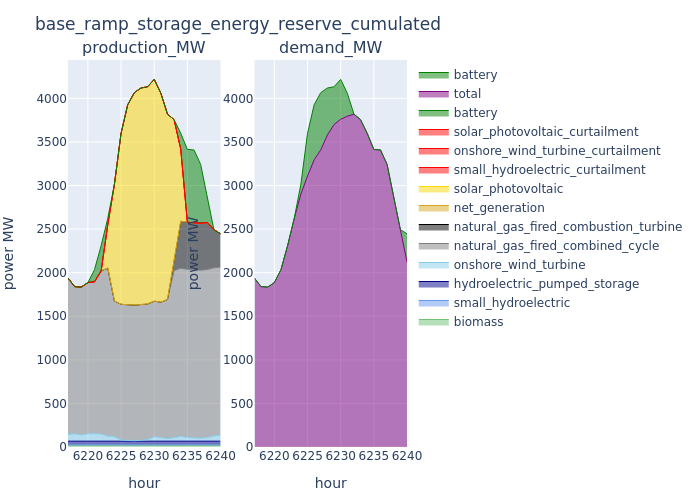

In [15]:
config_ = :base_ramp_storage_energy_reserve_cumulated
supply_uc_ = supply_uc[(supply_uc.configuration .== config_) .& (supply_uc.day .== day_), :]
demand_uc_ = demand_uc[(demand_uc.configuration .== config_) .& (demand_uc.day .== day_), :]
plot_supply_demand(supply_uc_, demand_uc_, string(config_))

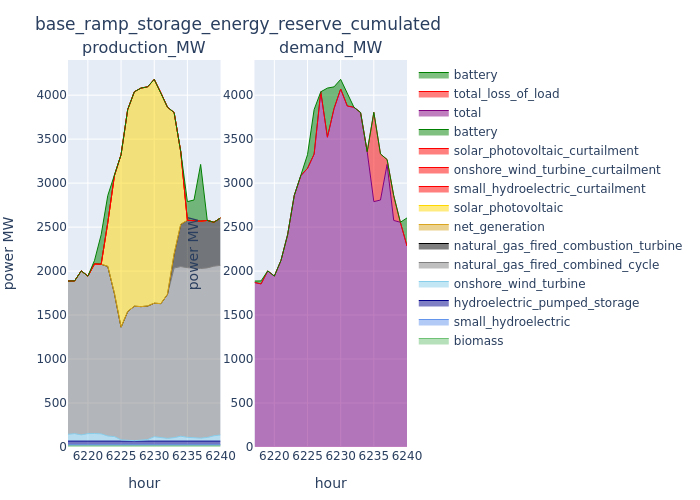

In [16]:
config_ = :base_ramp_storage_energy_reserve_cumulated
supply_ed_ = supply_ed[(supply_ed.configuration .== config_) .& (supply_ed.day .== day_) .& (supply_ed.iteration .== iteration_), :]
demand_ed_ = demand_ed[(demand_ed.configuration .== config_) .& (demand_ed.day .== day_) .& (demand_ed.iteration .== iteration_), :]
plot_supply_demand(supply_ed_, demand_ed_, string(config_))


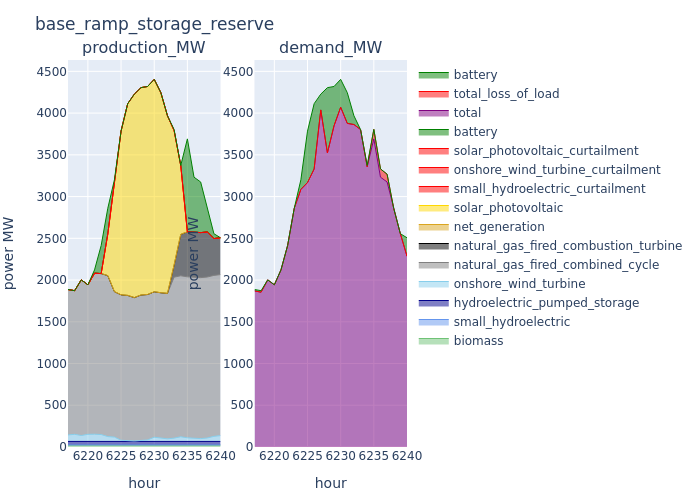

In [17]:
config_ = :base_ramp_storage_reserve
supply_ed_ = supply_ed[(supply_ed.configuration .== config_) .& (supply_ed.day .== day_) .& (supply_ed.iteration .== iteration_), :]
demand_ed_ = demand_ed[(demand_ed.configuration .== config_) .& (demand_ed.day .== day_) .& (demand_ed.iteration .== iteration_), :]
plot_supply_demand(supply_ed_, demand_ed_, string(config_))


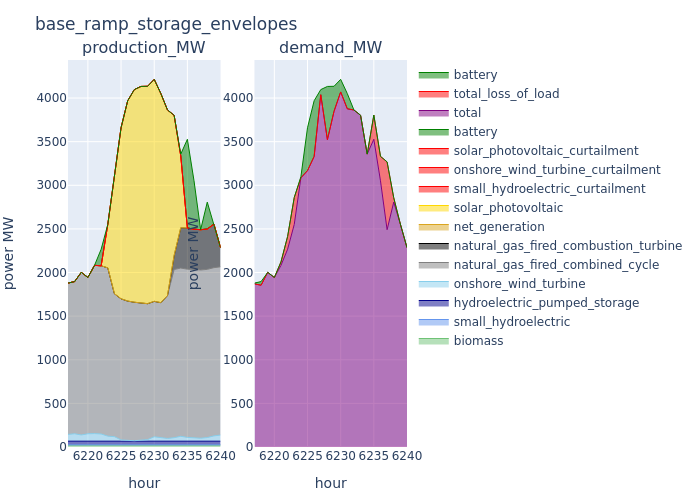

In [18]:
config_ = :base_ramp_storage_envelopes
supply_ed_ = supply_ed[(supply_ed.configuration .== config_) .& (supply_ed.day .== day_) .& (supply_ed.iteration .== iteration_), :]
demand_ed_ = demand_ed[(demand_ed.configuration .== config_) .& (demand_ed.day .== day_) .& (demand_ed.iteration .== iteration_), :]
plot_supply_demand(supply_ed_, demand_ed_, string(config_))

### Other

In [19]:
plot_reserve(reserve_, "Storage + SOC Imprudent")

UndefVarError: UndefVarError: `reserve_` not defined

In [20]:
supply_ = supply_uc[supply_uc.configuration .== :base_ramp_storage_envelopes, :]
demand_ = demand_uc[demand_uc.configuration .== :base_ramp_storage_envelopes, :]
solution_reserve_ = s_uc.reserve[s_uc.reserve.configuration .== :base_ramp_storage_envelopes, :]
reserve_ = calculate_reserve(solution_reserve_, required_reserve)
plot_supply_demand(supply_, demand_,"Storage + SOC Envelopes")

UndefVarError: UndefVarError: `required_reserve` not defined

In [21]:
plot_reserve(reserve_, "Storage + SOC Envelopes")

UndefVarError: UndefVarError: `reserve_` not defined

In [22]:
supply_ = supply_uc[supply_uc.configuration .== :base_ramp_storage_energy_reserve_cumulated, :]
demand_ = demand_uc[demand_uc.configuration .== :base_ramp_storage_energy_reserve_cumulated, :]
solution_reserve_ = s_uc.reserve[s_uc.reserve.configuration .== :base_ramp_storage_energy_reserve_cumulated, :]
reserve_ = calculate_reserve(solution_reserve_, required_reserve)
plot_supply_demand(supply_, demand_,"Storage + Energy Reserve")

UndefVarError: UndefVarError: `required_reserve` not defined

In [23]:
plot_reserve(reserve_, "Storage + Energy Reserve")

UndefVarError: UndefVarError: `reserve_` not defined

## Other

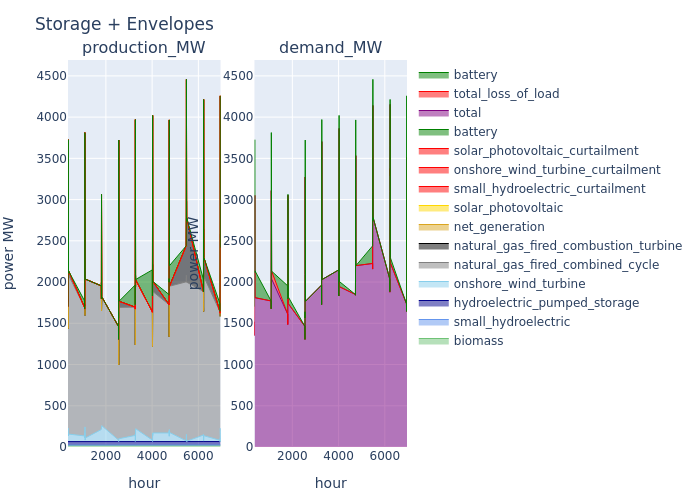

In [24]:
demand_ = :demand_28
supply_ed_ = supply_ed[(supply_ed.configuration .== :base_ramp_storage_envelopes).&(supply_ed.iteration .== demand_), :]
demand_ed_ = demand_ed[(demand_ed.configuration .== :base_ramp_storage_envelopes).&(demand_ed.iteration .== demand_), :]
# solution_reserve_ = s_uc.reserve[s_uc.reserve.configuration .== :base_ramp_storage_envelopes, :]
# reserve_ = calculate_reserve(solution_reserve_, required_reserve)
plot_supply_demand(supply_ed_, demand_ed_,"Storage + Envelopes")
# p1 = plot_fieldx_by_fieldy(supply_ed_, :production_MW, :resource, "ED - Storage + SOC Envelopes")

# p2 = plot_fieldx_by_fieldy(supply_ed_, :production_MW, :resource, "ED - Storage + Energy Reserve")

# [p1 p2]

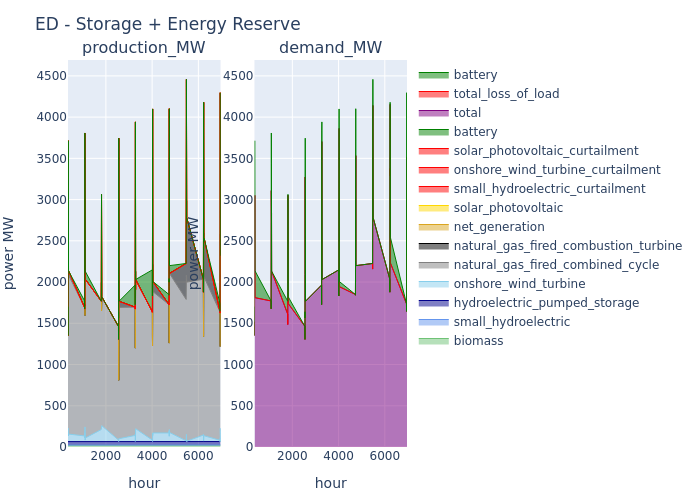

In [25]:
supply_ed_ = supply_ed[(supply_ed.configuration .== :base_ramp_storage_energy_reserve_cumulated).&(supply_ed.iteration .== demand_), :]
demand_ed_ = demand_ed[(demand_ed.configuration .== :base_ramp_storage_energy_reserve_cumulated).&(demand_ed.iteration .== demand_), :]
plot_supply_demand(supply_ed_, demand_ed_,"ED - Storage + Energy Reserve")

In [26]:
get_day = 1
days = unique(s_ed.generation.day)
gen_df, loads_multi_df, gen_variable_multi_df, storage_df, random_loads_multi_df = generate_input_data(days[get_day], "../input/base_case")
required_reserve, required_energy_reserve, required_energy_reserve_cumulated = generate_reserves(loads_multi_df, gen_variable_multi_df, 0.1)
;

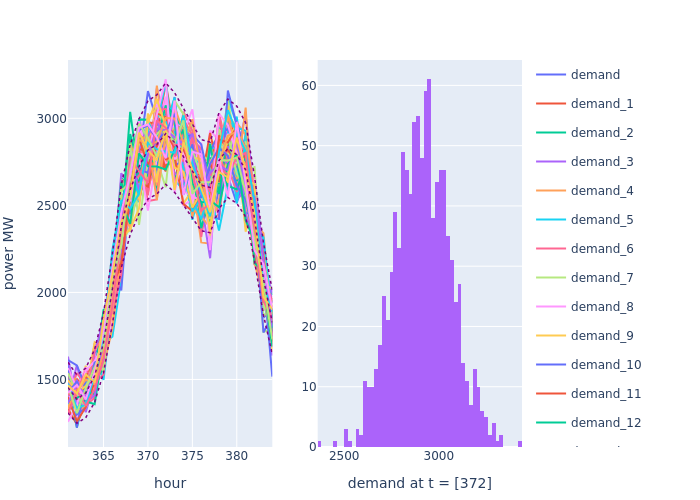

In [27]:
select_first = 100
to_plot_demand = stack(random_loads_multi_df[!,1:(select_first+1)], Not(:hour))
to_plot_reserve = copy(required_reserve)
to_plot_reserve.reserve_up_MW = required_reserve.reserve_up_MW .+ random_loads_multi_df[!,:demand]
to_plot_reserve.reserve_down_MW = -required_reserve.reserve_down_MW .+ random_loads_multi_df[!,:demand]
to_plot_reserve.demand_MW = random_loads_multi_df[!,:demand]
to_plot_reserve = stack(to_plot_reserve, Not(:hour))
s= scatter(to_plot_demand, x = :hour, y = :value, group = :variable)
s1 = scatter(to_plot_reserve, x = :hour, y = :value, group = :variable, line=attr(color="purple", width=1.5, dash="dot"))
union!(s,s1)
p1 = plot(s, Layout(yaxis_title="power MW", xaxis_title="hour"))

t_ = loads_multi_df[loads_multi_df.demand .== maximum(loads_multi_df.demand),:hour]
to_plot_histogram = stack(random_loads_multi_df[random_loads_multi_df.hour .== t_, :])
p2 = plot(to_plot_histogram, x = :value, kind="histogram", histonorm = "percent", Layout(xaxis_title_text="demand at t = $t_"))

[p1 p2]